# Python Twitch API Tutorial

This article will serve as a brief introduction to the integration of Python and the Twitch API.  For the API documentation, visit https://dev.twitch.tv/docs/.  This specific implementation will take place in the Jupyter Notebook environment. 
***

## Step 1 - Register App
The first action that must be taken is making a Twitch account.  This is required to register an app to receive the credentials necessary to interact with the API.  Once you have an account, go to the dev console on Twitch and register the app.  Give it whatever name you want and set the redirect URL to `http://localhost` for local testing.  This is the URL you will be directed to if making an auth token request of a user and can be changed at a later time.

Once you have the app registered, there are 2 important variables. The client id and secret are the identifiers for your app that grant you permission to use the API.  Note that they should not be publicly visible. 

To keep these credentials hidden, create an empty .py file in the project directory, and name it something like `secret` or `credentials` (this is what I will use in this example).  If the project is stored in a public repository, make sure to add this file to the .gitignore.  Within the .py file, add the following lines, replacing the xxx's with the random string of letters. 

```
client_id = 'xxxxxxxxxxxxxxxxxxxxx'
secret = 'xxxxxxxxxxxxxxxxxxxxx'
```

Import these variables into the python environment

In [ ]:
# import the file we created with our client_id and secret variables
import credentials
client_id = credentials.client_id
secret = credentials.secret

***

## Step 2 - Authentication

Different pieces of information require different forms of authentication.  Requesting public information requires an App Authentication token.  Personal user information requires a User token.  For this example I just want generic public information on channels, so according to the documentation I should use the OAuth client credentials flow.  For apps that require special user permissions, this is where you will set your redirect url and use a different flow for user access tokens with the necessary scopes.

**OAuth client credentials flow:**

```
POST https://id.twitch.tv/oauth2/token

    ?client_id=<your client ID>
    
    &client_secret=<your client secret>
    
    &grant_type=client_credentials
    
    &scope=<space-separated list of scopes>
```

In [138]:
# To make this request in Python, we use the `requests` library
# The json library is used to parse the response
import requests, json
# the URL base 
def get_token():
    '''
    Returns an OAuth client credentials flow App token for an associated client id.
    Prints the status code (200 = success, 400 = failure).
    Prints the token expiration.
    '''
    auth_url = 'https://id.twitch.tv/oauth2/token'
    # parameters for token request with credentials
    auth_params = {'client_id': client_id,
                   'client_secret': secret,
                   'grant_type': 'client_credentials',
                   'scope':''}
    # Request response, using the url base and params to structure the request
    auth_response = requests.post(auth_url, params = auth_params)
    # Status code 200 means the request was successful
    print(f'Status code: {auth_response.status_code}')
    # Get the expiration time of token in seconds, divide by 3600 to get hours
    exp_time = round(auth_response.json()['expires_in'] / 3600, 2)
    print(f'This token expires in {exp_time} hours')
    token = auth_response.json()['access_token']
    return token

In [128]:
# call the function to get the token
token = get_token()

Status code: 200
This token expires in 1510.37 hours


***

## Step 3 - Make Requests

Now that we have an access token, we can make requests.  Twitch has depricated the v5 and kraken APIs so helix is the version that should be used.  Whenever a request is made, the client id and authorization token need to be passed as headers.  Some of the types of queries that can be made are:

* get games
* get top games
* search categories
* search channels
* get streams
* get tags
* get users
* get user follows etc.

Some queries require special permissions or scopes and need the authorization of the user.  Note that the API has a rate limit of 800 points per minute (requests by token).

In [131]:
# takes the query type (users, channels, games, streams etc)
# the argument being searched for (id, login, display_name) etc
# and the channel (ie: gmhikaru (for login), 103268673 (for id))
def request_it(query, fields):
    '''
    Makes a GET request from the Twitch.tv helix API.
    Receives a string for the query ex: users, games/top, search/categories...,
    and a dict for the field parameter ex: {'login': 'gmhikaru'}
    '''
    # the base url for making api requests
    base_url = 'https://api.twitch.tv/helix/'
    # authorization information
    headers = {'client-id': client_id,
               'Authorization': f'Bearer {token}'}
    # type of query, users gets the 
    response = requests.get(base_url + query,
                            headers = headers,
                            params = fields)
    print(f'Status code: {response.status_code}')
    print(f'Request URL: {response.url}')
    return response.json()

For example, to look up a specific channel by the username, we can specify `./helix/users` and `login=gmhikaru`.

In [87]:
request_it('users', {'login':'gmhikaru'})

Status code: 200
Request URL: https://api.twitch.tv/helix/users?login=gmhikaru


{'data': [{'id': '103268673',
   'login': 'gmhikaru',
   'display_name': 'GMHikaru',
   'type': '',
   'broadcaster_type': 'partner',
   'description': 'Grandmaster Hikaru Nakamura, 5-time United States Chess Champion ',
   'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/cd921fcd-53fc-4b1d-be23-0787bc36b756-profile_image-300x300.png',
   'offline_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/cc6af6f3-acb3-4a32-8223-13de1d2aadd1-channel_offline_image-1920x1080.png',
   'view_count': 37784077,
   'created_at': '2015-09-29T10:35:23.386423Z'}]}

Using this function we can begin collecting a dataset.  But first we will need to generate a list of streams to get data on.
***

## Step 4 - Collect Data

The json format in which the data is returned can be easily converted into a structured dataset using pandas.  First, a loop is using the `./helix/streams` API, returning 100 results on the page. Then, the cursor information is passed in recursion to move to the subsequent page.  Storing each page in a list and then unwrapping the list of pages gives a sequential list of all the top currently live streams sorted by viewer count.

Note that it is important to limit the frequency of requests - to not to place undue network burden on the server you are requesting from, or hit the rate-limit for your token/IP address causing a negative status code error. 

In [136]:
def unwrap_list_of_lists(list_of_lists):
    '''
    Unwraps list of list structures.
    Receives a nested list structure [list0, list1, list2, ...].
    Returns each of the elements from each of the lists as an unnested list.
    '''
    lst = []
    for i in range(len(list_of_lists)):
        for j in range(len(list_of_lists[i])):
            lst.append(list_of_lists[i][j])
        print(len(lst))
    return lst

In [140]:
import time
def get_stream_list(n_pages = 1):
    '''
    Gets the top 100 currently live streams per page, sorted by viewer count.
    The argument is n_pages, number of pages to be queried.
    Prints the status code (200 = success, 400 = failure) per request.
    Prints the request URL per page.
    Prints the number of elements per page.
    '''
    pages = []
    cursor = ''
    for i in range(n_pages):
        response = request_it('streams', {'first': 100,
                                          'after': cursor})
        cursor = response['pagination']['cursor']
        pages.append(response['data'])
        time.sleep(.2)
    return unwrap_list_of_lists(pages)

In [137]:
# Call the function to get list of live channels
stream_list = get_stream_list()

Status code: 200
Request URL: https://api.twitch.tv/helix/streams?first=100&after=
99


Now that the data exists a list of dictionaries, it is as simple as calling pd.DataFrame() to convert it into a useable dataset

In [139]:
import pandas as pd
df = pd.DataFrame(stream_list)[['user_id','user_name', 'language', 'viewer_count', 'game_name']]
df

,user_id,user_name,language,viewer_count,game_name
0,83399952,UNLOSTV,tr,96981,Just Chatting
1,83232866,ibai,es,78999,Among Us
2,233334675,battlestategames,en,51365,Escape From Tarkov
3,31239503,ESL_CSGO,en,48942,Counter-Strike: Global Offensive
4,15564828,NICKMERCS,en,48391,Call of Duty: Warzone
...,...,...,...,...,...
94,254756234,KristoferYee,en,5478,Minecraft
95,26560695,Shiphtur,en,5475,League of Legends
96,59965916,RduLIVE,en,5414,Hearthstone
97,174955366,Solary,fr,5374,League of Legends


In [114]:
df.describe()

,viewer_count
count,9953.000000
mean,327.814428
std,2248.913383
min,0.000000
25%,30.000000
50%,52.000000
75%,128.000000
max,104824.000000


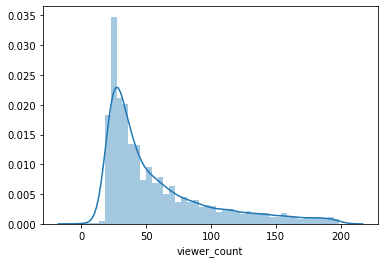

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.distplot(df.viewer_count.loc[df.viewer_count<200])

***